# Load Data

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import string
import re
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Feature Extraction
Add features:
- Total word counts (cleaned)
- Urls per comment
- Question marks per comment
- Sklearn vectorizer


**Start from the cleanpost data**

In [3]:
# new_path = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_train.csv'
new_path = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_train.csv'
df_train = pd.read_csv(new_path).drop(columns=['Unnamed: 0'])

In [4]:
df_train['http_per_comment'] = df_train['posts'].apply(lambda x: x.count('http')/50)
df_train['qm_per_comment'] = df_train['posts'].apply(lambda x: x.count('?')/50)

In [5]:
# new_path_test = '/content/drive/MyDrive/CS289A Project/data/cleaned_mbti_test.csv'
new_path_test = '/content/drive/MyDrive/CS289A Project/data/old data (w o removing mbti words)/cleaned_mbti_test.csv'
df_test = pd.read_csv(new_path_test).drop(columns=['Unnamed: 0'])

In [6]:
df_test['http_per_comment'] = df_test['posts'].apply(lambda x: x.count('http')/50)
df_test['qm_per_comment'] = df_test['posts'].apply(lambda x: x.count('?')/50)

**Vectorize Clean Posts**

In [7]:
# Tf-idf vectorizer
nfeat = 5000
vectorizer = TfidfVectorizer(max_features=nfeat) # max_features may change
vectorizer.fit(df_train.clean_posts)
feature_names=vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [8]:
# Tf-idf vectorizer
train_post=vectorizer.transform(df_train.clean_posts).toarray()
test_post=vectorizer.transform(df_test.clean_posts).toarray()

Concatonate all features to get a **train_design** matrix\
Whitening all features

In [9]:
# concatenate other features
train_remain = np.stack((df_train.clean_word_counts, df_train.http_per_comment, df_train.qm_per_comment), axis=1)
train_design = np.concatenate((train_post,train_remain), axis=1)

# concatenate other features
test_remain = np.stack((df_test.clean_word_counts, df_test.http_per_comment, df_test.qm_per_comment), axis=1)
test_design = np.concatenate((test_post,test_remain), axis=1)

In [10]:
X_train_list = []; X_test_list = []
# 0. tfid + 3 add feats w/o whitening
X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [11]:
# 1. tfid + 3 add feats with whitening the 3 add feats.
train_mean = np.average(train_design,axis=0)
train_var = np.average(train_design,axis=0)
train_design[:,-3:]=(train_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])
test_design[:,-3:]=(test_design[:,-3:] - train_mean[-3:]) / np.sqrt(train_var[-3:])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [12]:
# 2. tfid + 3 add feats with whitening all feats
train_design[:,:-3]=(train_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])
test_design[:,:-3]=(test_design[:,:-3] - train_mean[:-3]) / np.sqrt(train_var[:-3])

X_train_list.append(np.copy(train_design)); X_test_list.append(np.copy(test_design))

In [13]:
# 3. tfid w/o whitening
X_train_list.append(np.copy(X_train_list[0][:,:-3])); X_test_list.append(np.copy(X_test_list[0][:,:-3]));
# 4. tfid with whitening
X_train_list.append(np.copy(X_train_list[2][:,:-3])); X_test_list.append(np.copy(X_test_list[2][:,:-3]));

**Setting up y-labels**: 16 classes (ranging from 0-15 representing 16 Myers-briggs personality types)\
INFJ - 0\
INFP - 1\
INTJ - 2\
INTP - 3\
ISFJ - 4\
ISFP - 5\
ISTJ - 6\
ISTP - 7\
ENFJ - 8\
ENFP - 9\
ENTJ - 10\
ENTP - 11\
ESFJ - 12\
ESFP - 13\
ESTJ - 14\
ESTP - 15


In [14]:
# train/test_pers_bin : splitted MBTI types
# I/E  N/S  F/T  J/P
pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
def trans_per(mtype):
  return [pers[l] for l in mtype]

def bin_2_num(bin):
  res = 0; n = len(bin)
  for ielem, bin_val in enumerate(bin):
    res += bin_val*pow(2,n-1-ielem)
  return res

# can train each personality
train_pers_bin = np.array([trans_per(p) for p in df_train.type])
# train_target
train_target = np.array([bin_2_num(bin) for bin in train_pers_bin])


In [15]:
class16_mbti_map = {
    0:"INFJ",
    1:"INFP",
    2:"INTJ",
    3:"INTP",
    4:"ISFJ",
    5:"ISFP",
    6:"ISTJ",
    7:"ISTP",
    8:"ENFJ",
    9:"ENFP",
    10:"ENTJ",
    11:"ENTP",
    12:"ESFJ",
    13:"ESFP",
    14:"ESTJ",
    15:"ESTP",
}

In [16]:
# can train each personality
test_pers_bin = np.array([trans_per(p) for p in df_test.type])
# train_target
test_target = np.array([bin_2_num(bin) for bin in test_pers_bin])

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [18]:
cv = 5 # May change

In [19]:
y_train = np.copy(train_target)
y_test = np.copy(test_target)

**Brief dim reduction**

In [20]:
from sklearn.decomposition import PCA
pca_dim = 500
for ielem in range(5):
  pca = PCA(n_components=pca_dim,random_state=248)
  tmp_train = pca.fit_transform(X_train_list[ielem])
  tmp_test = pca.transform(X_test_list[ielem])
  X_train_list.append(tmp_train)
  X_test_list.append(tmp_test)

**Aug data**

In [21]:
if False:
  # Add Aug Data
  root_path = '/content/drive/MyDrive/CS289A Project/'
  data_path = root_path + 'data/'
  train_aug_data_path = data_path + 'df_train_aug.csv'
  train_aug = pd.read_csv(train_aug_data_path)

  test_aug_data_path = data_path + 'df_test_aug.csv'
  test_aug = pd.read_csv(test_aug_data_path)
  X_train_aug = train_aug.to_numpy()[:,1:]
  X_test_aug = test_aug.to_numpy()[:,1:]
  train_mean_aug = np.average(X_train_aug,axis=0)
  train_var_aug = np.var(X_train_aug, axis=0)
  X_train_aug = (X_train_aug-train_mean_aug)/np.sqrt(train_var_aug)
  X_test_aug = (X_test_aug-train_mean_aug)/np.sqrt(train_var_aug)

  X_train_list.append(X_train_aug)
  X_test_list.append(X_test_aug)

**Sanity check**
- The list of design matrices consist of
0. Tfid vector with add. features(n_features = nfeat+3) w/o whitening
1. Tfid vector with add. features(n_features = nfeat+3) with whitening 3 add feats. 
2. Tfid vector with add. features(n_features = nfeat+3) with complete whitening
3. Tfid vector w/o add. features(n_features = nfeat) w/o whitening
4. Tfid vector w/o add. features(n_features = nfeat) with whitening
5. PCA of 0.
6. PCA of 1.
7. PCA of 2.
8. PCA of 3.
9. PCA of 4.

In [22]:
print('nfeat = ', nfeat)
print('pca_dim = ', pca_dim)
for design in X_train_list:
  print(design.shape)

nfeat =  5000
pca_dim =  500
(6940, 5003)
(6940, 5003)
(6940, 5003)
(6940, 5000)
(6940, 5000)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)
(6940, 500)


# (DONE) DESIGN MATRICES

# Classification
- Logistic Regression
- SVM
- QDA
- Boosting (this case ada)
- Decision Tree Classifier
- Random Forest
1. compare CV accuracies of all classifiers (GridSearchCV or RandomizedSearchCV)
2. hyperparameter tuning
3. feature selection
4. visualization -- T-sne https://distill.pub/2016/misread-tsne/ compress 2000 features into 2D or 3D,
5. include error bars if appropriate (classifiers with randomness included)


In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.metrics import make_scorer

# Scores helper function
scoring = ['accuracy', 'precision_macro', 'recall_macro','f1_macro']
def CalculateScoresMultiClass(y_test, y_pred, model_name, is_train=False):
  scores = {}
  scores['Model'] = model_name
  scores['is_Train'] = is_train
  scores['Test_Accuracy'] = accuracy_score(y_test, y_pred)
  scores['Test_Precision'] = precision_score(y_test, y_pred, average='macro')
  scores['Test_Recall'] = recall_score(y_test, y_pred, average='macro')
  scores['F1'] = f1_score(y_test, y_pred, average='macro')
  return scores

def valScores2Dict(scores_input, model_name, is_train):
  scores = {}
  scores['Model'] = model_name
  scores['is_Train'] = is_train
  scores['Test_Accuracy'] = scores_input['test_accuracy'].mean()
  scores['Test_Precision'] = scores_input['test_precision_macro'].mean()
  scores['Test_Recall'] = scores_input['test_recall_macro'].mean()
  scores['F1'] = scores_input['test_f1_macro'].mean()
  return scores

In [58]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [59]:
if True:
  import warnings
  warnings.filterwarnings("ignore")

## **1. Logistic Regression**

design matrix 3, pca=300

### Tuning

### Best Model

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from scipy.stats import loguniform

In [62]:
# Dataset
pca = PCA(n_components=300,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[3])
X_test_tmp = pca.transform(X_test_list[3])

# Best Model Fit
best_logreg = LogisticRegression(
    max_iter=300, tol=1e-3, random_state=289, 
    C= 0.8, penalty= 'l1', solver= 'liblinear')
best_logreg.fit(X_train_tmp, y_train)

# Best Model Predict
y_pred = best_logreg.predict(X_test_tmp)
y_pred_train = best_logreg.predict(X_train_tmp)

# Results
scores_logreg_train = CalculateScoresMultiClass(y_train, y_pred_train, 'LogReg', is_train=True)
scores_logreg_test = CalculateScoresMultiClass(y_test,y_pred, 'LogReg', is_train=False)
scores = cross_validate(best_logreg, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_logreg_train_cv = valScores2Dict(scores, 'LogReg', is_train=True)

cm_logreg = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.70      0.75      0.72      1176
        INFP       0.69      0.85      0.76      1466
        INTJ       0.69      0.73      0.71       873
        INTP       0.70      0.81      0.75      1043
        ISFJ       0.76      0.48      0.59       133
        ISFP       0.77      0.46      0.57       217
        ISTJ       0.69      0.41      0.52       164
        ISTP       0.75      0.65      0.69       270
        ENFJ       0.71      0.30      0.42       152
        ENFP       0.70      0.64      0.67       540
        ENTJ       0.80      0.41      0.54       185
        ENTP       0.70      0.64      0.67       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.74      0.20      0.31        71

    accuracy                           0.70      

## **2. SVM**

design matrix 3, pca=200

### Tuning

### Best Model

In [63]:
from sklearn.svm import SVC

In [64]:
# Dataset
pca = PCA(n_components=200,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[3])
X_test_tmp = pca.transform(X_test_list[3])

# Best Model fit
best_svm_clf = SVC(max_iter=-1, tol=1e-3, random_state=1,
                   C= 0.14, kernel= 'rbf')
best_svm_clf.fit(X_train_tmp, y_train)

# Best model Predict
y_pred = best_svm_clf.predict(X_test_tmp)
y_pred_train = best_svm_clf.predict(X_train_tmp)

# Best model results
scores_svm_train = CalculateScoresMultiClass(y_train, y_pred_train, 'SVM', is_train=True)
scores_svm_test = CalculateScoresMultiClass(y_test,y_pred, 'SVM', is_train=False)
scores = cross_validate(best_svm_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_svm_train_cv = valScores2Dict(scores, 'SVM', is_train=True)

cm_svm = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.71      0.70      0.70      1176
        INFP       0.47      0.93      0.63      1466
        INTJ       0.77      0.66      0.71       873
        INTP       0.64      0.81      0.72      1043
        ISFJ       1.00      0.06      0.11       133
        ISFP       0.75      0.01      0.03       217
        ISTJ       0.80      0.02      0.05       164
        ISTP       0.82      0.33      0.47       270
        ENFJ       0.00      0.00      0.00       152
        ENFP       0.83      0.49      0.62       540
        ENTJ       0.92      0.12      0.21       185
        ENTP       0.82      0.50      0.62       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71

    accuracy                           0.62      

## **3. QDA**

QDA : design matrix 8, PCA=500

In [65]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

### Tuning

### Best Model

In [66]:
# Dataset
X_train_tmp = X_train_list[8]
X_test_tmp = X_test_list[8]

# Best model fit
best_qda_clf = QuadraticDiscriminantAnalysis()
best_qda_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_qda_clf.predict(X_test_tmp)
y_pred_train = best_qda_clf.predict(X_train_tmp)

# Results
scores_qda_train = CalculateScoresMultiClass(y_train, y_pred_train, 'QDA', is_train=True)
scores_qda_test = CalculateScoresMultiClass(y_test,y_pred, 'QDA', is_train=False)
scores = cross_validate(best_qda_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_qda_train_cv = valScores2Dict(scores, 'QDA', is_train=True)


cm_qda = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.85      1.00      0.92      1176
        INFP       0.59      1.00      0.74      1466
        INTJ       0.98      1.00      0.99       873
        INTP       0.95      1.00      0.97      1043
        ISFJ       1.00      0.01      0.01       133
        ISFP       0.00      0.00      0.00       217
        ISTJ       1.00      0.01      0.01       164
        ISTP       0.00      0.00      0.00       270
        ENFJ       0.00      0.00      0.00       152
        ENFP       1.00      1.00      1.00       540
        ENTJ       0.00      0.00      0.00       185
        ENTP       1.00      1.00      1.00       548
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        38
        ESTJ       0.00      0.00      0.00        31
        ESTP       0.00      0.00      0.00        71

    accuracy                           0.81      

## **3-1. LDA**

LDA : design matrix 6, PCA=38

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Tuning

### Best Model

In [68]:
# Dataset
pca = PCA(n_components=38,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[6])
X_test_tmp = pca.transform(X_test_list[6])

# Best model fit
best_lda_clf = LinearDiscriminantAnalysis()
best_lda_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_lda_clf.predict(X_test_tmp)
y_pred_train = best_lda_clf.predict(X_train_tmp)

# Results
scores_lda_train = CalculateScoresMultiClass(y_train, y_pred_train, 'LDA', is_train=True)
scores_lda_test = CalculateScoresMultiClass(y_test,y_pred, 'LDA', is_train=False)
scores = cross_validate(best_lda_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_lda_train_cv = valScores2Dict(scores, 'LDA', is_train=True)

cm_lda = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.75      0.68      0.71      1176
        INFP       0.71      0.80      0.75      1466
        INTJ       0.73      0.68      0.71       873
        INTP       0.70      0.78      0.73      1043
        ISFJ       0.57      0.53      0.55       133
        ISFP       0.60      0.59      0.59       217
        ISTJ       0.59      0.62      0.61       164
        ISTP       0.69      0.70      0.69       270
        ENFJ       0.52      0.55      0.54       152
        ENFP       0.71      0.61      0.66       540
        ENTJ       0.57      0.56      0.57       185
        ENTP       0.71      0.64      0.67       548
        ESFJ       0.50      0.30      0.38        33
        ESFP       0.07      0.11      0.09        38
        ESTJ       0.35      0.26      0.30        31
        ESTP       0.39      0.45      0.42        71

    accuracy                           0.69      

## **4. Boosting**

XGBoosting : design matrix 1, max_depth=2, n_estimators=200

best_xgb_clf = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=max_depth,n_estimators=n_esti,learning_rate=0.1)

In [69]:
from xgboost import XGBClassifier

### Tuning

### Best Model

In [70]:
# Dataset
X_train_tmp = X_train_list[1]
X_test_tmp = X_test_list[1]

# Best model fit
max_depth=2
n_estimators=200
best_xgb_clf = XGBClassifier(gpu_id=0,tree_method='gpu_hist',max_depth=max_depth,n_estimators=n_estimators,learning_rate=0.1)

best_xgb_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_xgb_clf.predict(X_test_tmp)
y_pred_train = best_xgb_clf.predict(X_train_tmp)

# Results
scores_xgb_train = CalculateScoresMultiClass(y_train, y_pred_train, 'XGBoosting', is_train=True)
scores_xgb_test = CalculateScoresMultiClass(y_test,y_pred, 'XGBoosting', is_train=False)
scores = cross_validate(best_xgb_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_xgb_train_cv = valScores2Dict(scores, 'XGBoosting', is_train=True)

cm_xgb = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.83      0.84      0.83      1176
        INFP       0.83      0.89      0.86      1466
        INTJ       0.83      0.80      0.82       873
        INTP       0.82      0.86      0.84      1043
        ISFJ       0.96      0.88      0.92       133
        ISFP       0.92      0.80      0.85       217
        ISTJ       0.91      0.82      0.86       164
        ISTP       0.90      0.86      0.88       270
        ENFJ       0.92      0.79      0.85       152
        ENFP       0.85      0.81      0.83       540
        ENTJ       0.93      0.79      0.85       185
        ENTP       0.82      0.79      0.81       548
        ESFJ       1.00      1.00      1.00        33
        ESFP       0.97      0.95      0.96        38
        ESTJ       1.00      0.97      0.98        31
        ESTP       0.97      0.93      0.95        71

    accuracy                           0.84      

## **5. Decision Tree**


In [72]:
from sklearn.tree import DecisionTreeClassifier

### Tuning

### Best Model

In [73]:
# Dataset
pca = PCA(n_components=500,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[3])
X_test_tmp = pca.transform(X_test_list[3])

# Best model fit
best_dtc_clf = DecisionTreeClassifier(max_depth=10, random_state=289)
best_dtc_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_dtc_clf.predict(X_test_tmp)
y_pred_train = best_dtc_clf.predict(X_train_tmp)

# Results
scores_dtc_train = CalculateScoresMultiClass(y_train, y_pred_train, 'Decision Tree', is_train=True)
scores_dtc_test = CalculateScoresMultiClass(y_test,y_pred, 'Decision Tree', is_train=False)
scores = cross_validate(best_dtc_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_dtc_train_cv = valScores2Dict(scores, 'Decision Tree', is_train=True)

cm_dtc = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.58      0.85      0.69      1176
        INFP       0.69      0.86      0.77      1466
        INTJ       0.65      0.77      0.70       873
        INTP       0.82      0.77      0.79      1043
        ISFJ       0.72      0.35      0.47       133
        ISFP       0.50      0.36      0.42       217
        ISTJ       0.60      0.26      0.36       164
        ISTP       0.93      0.50      0.65       270
        ENFJ       0.73      0.28      0.41       152
        ENFP       0.86      0.60      0.71       540
        ENTJ       0.73      0.39      0.51       185
        ENTP       0.90      0.66      0.76       548
        ESFJ       1.00      0.06      0.11        33
        ESFP       1.00      0.11      0.19        38
        ESTJ       1.00      0.06      0.12        31
        ESTP       1.00      0.11      0.20        71

    accuracy                           0.70      

## **6. Random Forest Classifier**

Matrix 3, PC=500
RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=2)

### Tuning

### Best Model

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [76]:
# Dataset
pca = PCA(n_components=500,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[3])
X_test_tmp = pca.transform(X_test_list[3])

# Best model fit
best_rfc_clf = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=150, random_state=289)
best_rfc_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_rfc_clf.predict(X_test_tmp)
y_pred_train = best_rfc_clf.predict(X_train_tmp)

# Results
scores_rfc_train = CalculateScoresMultiClass(y_train, y_pred_train, 'Random Forest', is_train=True)
scores_rfc_test = CalculateScoresMultiClass(y_test,y_pred, 'Random Forest', is_train=False)
scores = cross_validate(best_rfc_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_rfc_train_cv = valScores2Dict(scores, 'Random Forest', is_train=True)

cm_rfc = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       1.00      1.00      1.00      1176
        INFP       1.00      1.00      1.00      1466
        INTJ       1.00      1.00      1.00       873
        INTP       1.00      1.00      1.00      1043
        ISFJ       1.00      1.00      1.00       133
        ISFP       1.00      1.00      1.00       217
        ISTJ       1.00      1.00      1.00       164
        ISTP       1.00      1.00      1.00       270
        ENFJ       1.00      1.00      1.00       152
        ENFP       1.00      1.00      1.00       540
        ENTJ       1.00      1.00      1.00       185
        ENTP       1.00      1.00      1.00       548
        ESFJ       1.00      1.00      1.00        33
        ESFP       1.00      1.00      1.00        38
        ESTJ       1.00      1.00      1.00        31
        ESTP       1.00      1.00      1.00        71

    accuracy                           1.00      

## **7. MLP Classifier**

In [77]:
from sklearn.neural_network import MLPClassifier

### Tuning

### Best Model

In [78]:
# Dataset
pca = PCA(n_components=500,random_state=248)
X_train_tmp = pca.fit_transform(X_train_list[3])
X_test_tmp = pca.transform(X_test_list[3])

# Best model fit
best_mlp_clf = MLPClassifier(alpha=0.05, hidden_layer_sizes=(20,), random_state=289)
best_mlp_clf.fit(X_train_tmp, y_train)

# Best model predict
y_pred = best_mlp_clf.predict(X_test_tmp)
y_pred_train = best_mlp_clf.predict(X_train_tmp)

# Results
scores_mlp_train = CalculateScoresMultiClass(y_train, y_pred_train, 'MLP', is_train=True)
scores_mlp_test = CalculateScoresMultiClass(y_test,y_pred, 'MLP', is_train=False)
scores = cross_validate(best_mlp_clf, X_train_tmp, y_train, cv=5, scoring=scoring)
scores_mlp_train_cv = valScores2Dict(scores, 'MLP', is_train=True)

cm_mlp = confusion_matrix(y_test, y_pred)

# Print Report
print('train classification report \n ',classification_report(y_train,y_pred_train,target_names=list(class16_mbti_map.values())))
print('test classification report \n ',classification_report(y_test,y_pred,target_names=list(class16_mbti_map.values())))

train classification report 
                precision    recall  f1-score   support

        INFJ       0.80      0.82      0.81      1176
        INFP       0.81      0.87      0.84      1466
        INTJ       0.80      0.82      0.81       873
        INTP       0.80      0.85      0.83      1043
        ISFJ       0.89      0.80      0.84       133
        ISFP       0.84      0.77      0.81       217
        ISTJ       0.86      0.80      0.83       164
        ISTP       0.87      0.86      0.87       270
        ENFJ       0.86      0.63      0.73       152
        ENFP       0.82      0.80      0.81       540
        ENTJ       0.88      0.76      0.82       185
        ENTP       0.80      0.80      0.80       548
        ESFJ       0.77      0.30      0.43        33
        ESFP       1.00      0.03      0.05        38
        ESTJ       1.00      0.16      0.28        31
        ESTP       0.81      0.65      0.72        71

    accuracy                           0.81      

#Model Comparison

In [79]:
import matplotlib.pyplot as plt

In [82]:
model_scores_list = [scores_logreg_train_cv, scores_logreg_test,
                     scores_svm_train_cv,scores_svm_test,
                     scores_qda_train_cv,scores_qda_test,
                     scores_lda_train_cv, scores_lda_test,
                     scores_dtc_train_cv, scores_dtc_test,
                     scores_rfc_train_cv,scores_rfc_test,
                     scores_xgb_train_cv,scores_xgb_test,
                     scores_mlp_train_cv, scores_mlp_test]

models_results = pd.DataFrame.from_dict(model_scores_list)
models_results.rename(columns={"Test_Accuracy": "Accuracy", "Test_Precision": "Precision", "Test_Recall": "Recall"}, inplace=True)
models_results

# Stores Results
#models_results.to_csv('model_results.csv', index=False)

,Model,is_Train,Accuracy,Precision,Recall,F1
0,LogReg,True,0.678386,0.571704,0.427556,0.459577
1,LogReg,False,0.650720,0.520318,0.389979,0.422328
2,SVM,True,0.544669,0.323172,0.236318,0.239482
3,SVM,False,0.576945,0.515632,0.275041,0.289345
4,QDA,True,0.249712,0.079850,0.078311,0.049791
5,QDA,False,0.304323,0.092902,0.101808,0.077359
6,LDA,True,0.679107,0.547845,0.519514,0.524768
7,LDA,False,0.672046,0.567130,0.516782,0.531921
8,Decision Tree,True,0.420461,0.262336,0.228713,0.234565
9,Decision Tree,False,0.429971,0.286248,0.225514,0.238467


In [83]:
models_results_train = models_results[models_results['is_Train']==True]
models_results_train.drop('is_Train',axis=1,inplace=True)
models_results_train

,Model,Accuracy,Precision,Recall,F1
0,LogReg,0.678386,0.571704,0.427556,0.459577
2,SVM,0.544669,0.323172,0.236318,0.239482
4,QDA,0.249712,0.079850,0.078311,0.049791
6,LDA,0.679107,0.547845,0.519514,0.524768
8,Decision Tree,0.420461,0.262336,0.228713,0.234565
10,Random Forest,0.545389,0.501687,0.261245,0.279817
12,XGBoosting,0.684150,0.680958,0.506435,0.552271
14,MLP,0.646398,0.576838,0.468785,0.498091


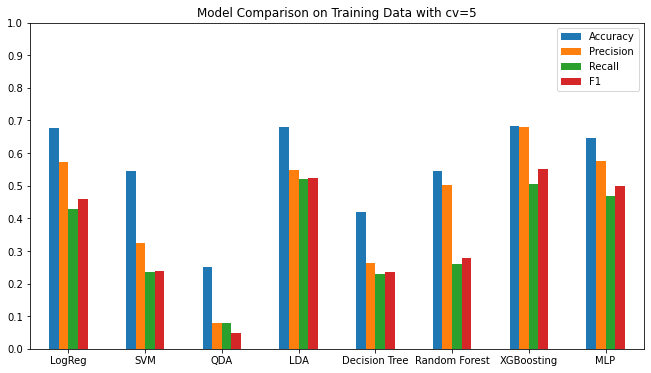

In [84]:
figsize = (11, 6)
ax = models_results_train.plot.bar(rot=0,figsize=figsize)
ax.set_xticklabels(models_results_train.Model)
ax.set_yticks(np.arange(0,1.1,0.1))
ax = plt.title('Model Comparison on Training Data with cv=5')

In [85]:
models_results_test = models_results[models_results['is_Train']==False]
models_results_test.drop('is_Train',axis=1,inplace=True)
models_results_test

,Model,Accuracy,Precision,Recall,F1
1,LogReg,0.650720,0.520318,0.389979,0.422328
3,SVM,0.576945,0.515632,0.275041,0.289345
5,QDA,0.304323,0.092902,0.101808,0.077359
7,LDA,0.672046,0.567130,0.516782,0.531921
9,Decision Tree,0.429971,0.286248,0.225514,0.238467
11,Random Forest,0.541210,0.490688,0.252442,0.266822
13,XGBoosting,0.665706,0.691377,0.517315,0.562852
15,MLP,0.651297,0.584134,0.473627,0.508781


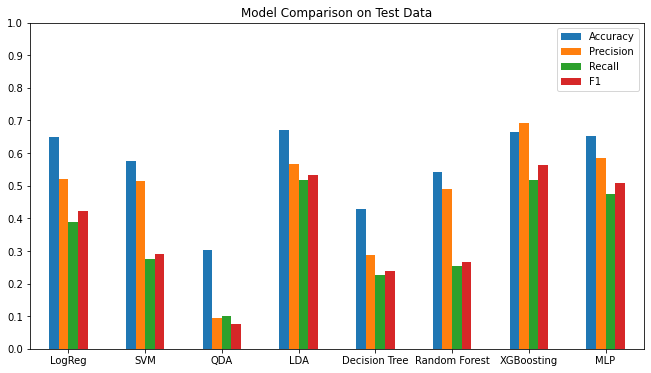

In [86]:
figsize = (11, 6)
ax = models_results_test.plot.bar(rot=0,figsize=figsize)
ax.set_xticklabels(models_results_test.Model)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.legend(loc=1)
ax = plt.title('Model Comparison on Test Data')

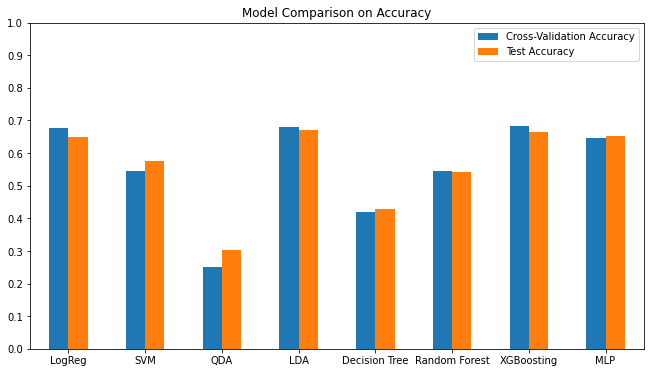

In [88]:
df_tmp1 = models_results_train.rename(columns={'Accuracy':'Cross-Validation Accuracy'}).drop(['Precision','Recall','F1'],axis=1)
df_tmp2 = models_results_test.rename(columns={'Accuracy':'Test Accuracy'}).drop(['Precision','Recall','F1'],axis=1)
df_tmp3 = df_tmp1.merge(df_tmp2, on='Model')

figsize = (11, 6)
ax = df_tmp3.plot.bar(rot=0,figsize=figsize)
ax.set_xticklabels(df_tmp3.Model)
ax.set_yticks(np.arange(0,1.1,0.1))
ax.legend(loc=1)
ax = plt.title('Model Comparison on Accuracy')

## Confusion Matrix Visualization

#### Plotting Helper

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(13, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Plots

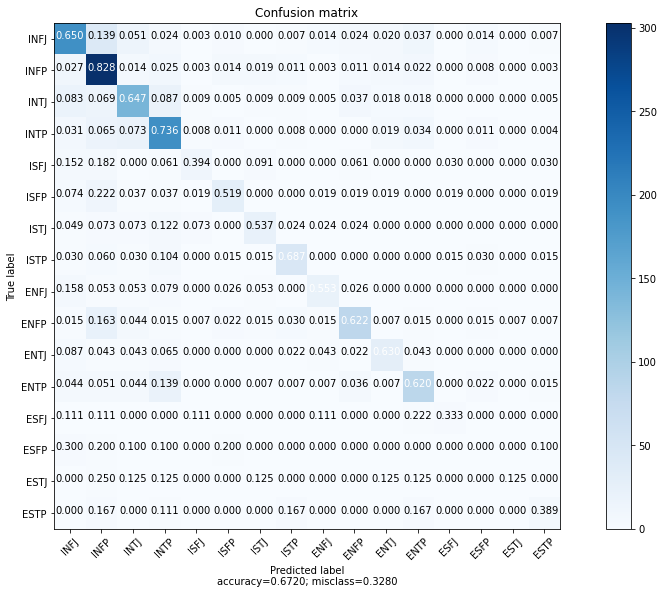

In [ ]:
# LDA
plot_confusion_matrix(cm_lda, list(class16_mbti_map.values()))

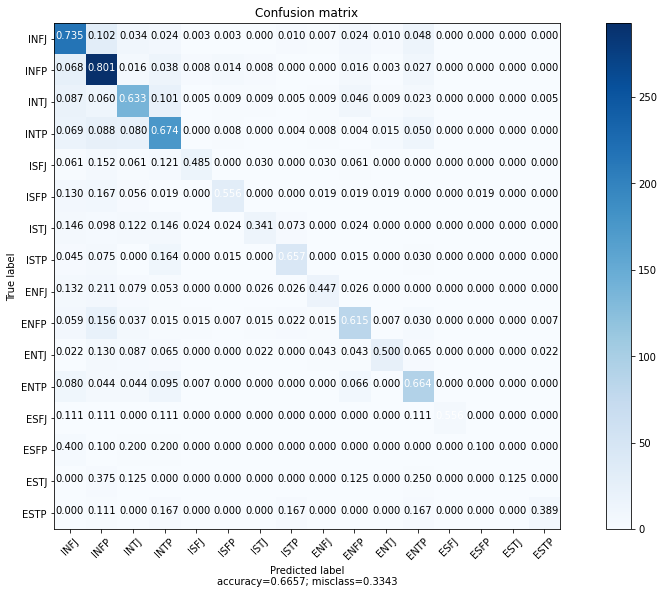

In [ ]:
# XGP
plot_confusion_matrix(cm_xgb, list(class16_mbti_map.values()))

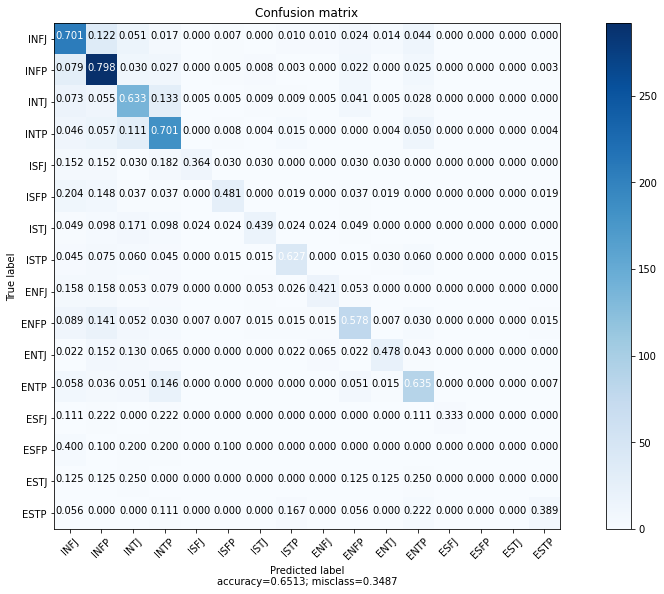

In [ ]:
# MLP
plot_confusion_matrix(cm_mlp, list(class16_mbti_map.values()))

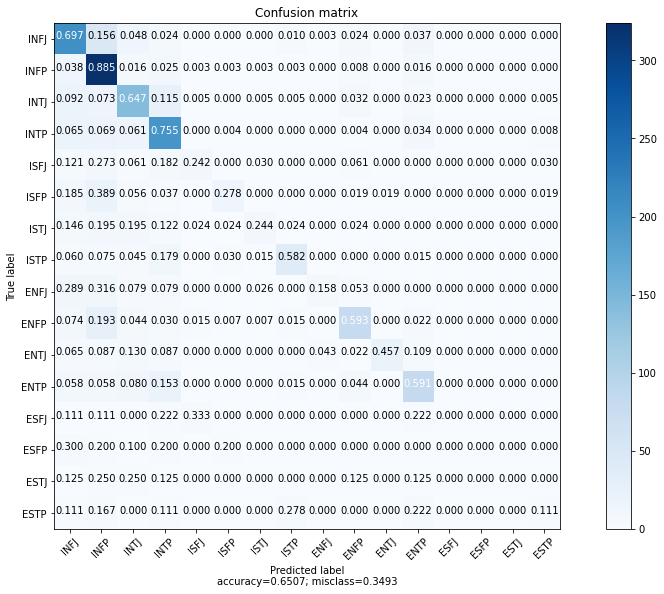

In [ ]:
# LogReg
plot_confusion_matrix(cm_logreg, list(class16_mbti_map.values()))